In [19]:
import h5py
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import RepeatVector, Dense, Dropout, Input, Convolution1D, LSTM, TimeDistributed
from keras.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline


def keras_model(max_unroll):
    inputs = Input(shape=(15,))

    x = RepeatVector(max_unroll)(inputs)
    x = TimeDistributed(Dense(64))(x)
    x = Dropout(0.1)(x)
    x = LSTM(64, return_sequences=True, dropout_U=0.05, dropout_W=0.1)(x)
    x = Convolution1D(50, 3, border_mode='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Convolution1D(20, 3, border_mode='same', activation='relu')(x)
    x = Dropout(0.1)(x)
    x = TimeDistributed(Dense(50, activation='relu'))(x)
    x = Dropout(0.1)(x)
    main_output = TimeDistributed(Dense(7), name='output')(x)
    mask_output = TimeDistributed(Dense(1, activation='sigmoid'), name='mask')(x)

    model = Model(input=inputs, output=[main_output, mask_output])

    model.compile(optimizer='adam', loss='mae', sample_weight_mode='temporal',
              metrics=[mean_absolute_error, mean_squared_error], loss_weights=[1., 1.])

    return model

In [20]:
model = keras_model(1502)
model.load_weights('save/model_checkpoint.499-mae2.919.hdf5')

In [21]:
path = 'DataBase/data.hdf5'
names = ['target_pos', 'target_speed', 'pos', 'vel', 'effort']
np.random.seed(1098)
data = list()
with h5py.File(path, 'r') as f:
    (target_pos, target_speed, pos, vel, effort) = [[np.array(val) for val in f[name].values()] for name in names]
# todo normalizar datos

x_target = np.array(target_pos)
x_first = np.array([pos_[0] for pos_ in pos])
x_speed = np.array(target_speed).reshape((-1, 1))
aux_output = [np.ones(eff.shape[0]).reshape((-1, 1)) for eff in effort]

x = np.concatenate((x_target, x_first, x_speed), axis=1)
y = pad_sequences(effort, padding='post', value=0.)
aux_output = pad_sequences(aux_output, padding='post', value=0.)
x, x_test, y, y_test, y_aux, y_aux_test = train_test_split(x, y, aux_output, test_size=0.2)

mask = y_aux[:, :, 0]
mask_test = y_aux_test[:, :, 0]
mask_aux = np.ones(y_aux.shape[0:2])
mask_aux_test = np.ones(y_aux_test.shape[0:2])

(122, 15)


(122, 1502, 7)


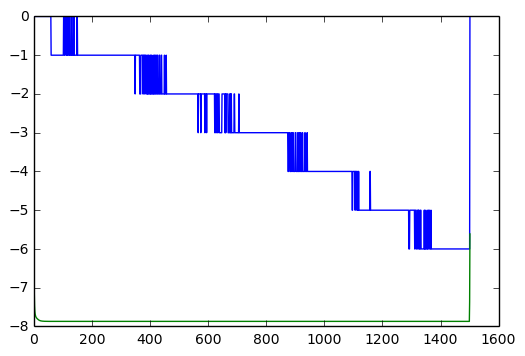

In [35]:
ejex = np.arange(y_test.shape[1])
print(x_test.shape)
pred = model.predict(x_test)
print(pred[0].shape)
plt.plot(ejex, y_test[0, :, 2], ejex, pred[0][0, :, 2])

In [ ]:
model.evaluate(x_test, [y_test, y_aux_test], sample_weight=[mask_test, mask_aux_test])